# EDA: Bike-Share Short-Term Forecasting

This notebook performs exploratory data analysis on the UCI `hour.csv` dataset (processed).
Follow the cells sequentially.

**Assumptions**
- Processed dataset is at `data/processed_hour.csv` with a `timestamp` datetime column and `cnt` target.
- If you haven't prepared the file yet, run:

In [2]:
from pathlib import Path
import subprocess
import sys

ROOT = Path.cwd().parent
raw_candidates = [
    ROOT / "data" / "hour.csv",
    ROOT / "data" / "bike+sharing+dataset" / "hour.csv",
]
processed_path = ROOT / "data" / "processed_hour.csv"
prepare_script = ROOT / "src" / "prepare.py"

raw_path = next((p for p in raw_candidates if p.exists()), None)
if raw_path and not processed_path.exists():
    cmd = [sys.executable, str(prepare_script), "--input", str(raw_path), "--output", str(processed_path)]
    print("Running:", " ".join(cmd))
    subprocess.run(cmd, check=False)
else:
    print("Skipping prepare step (raw data missing or processed file already present).")

Skipping prepare step (raw data missing or processed file already present).


In [3]:
# Load processed data (safe-path resolution) and basic imports
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

ROOT = Path.cwd().parent
PROC = ROOT / 'data' / 'processed_hour.csv'
RESULTS = ROOT / 'results'
RESULTS.mkdir(parents=True, exist_ok=True)

if PROC.exists():
    df = pd.read_csv(PROC, parse_dates=['timestamp'])
    print("Loaded:", PROC)
    print("Rows:", len(df))
else:
    raise FileNotFoundError(f"Processed data not found at {PROC}. Run: python src/prepare.py --input data/hour.csv --output data/processed_hour.csv")

Loaded: C:\Users\ericb\source\bike_forecast\data\processed_hour.csv
Rows: 17520


## Time series of counts

Plot a sample of the time series. If the dataset is long, we sample for readability.


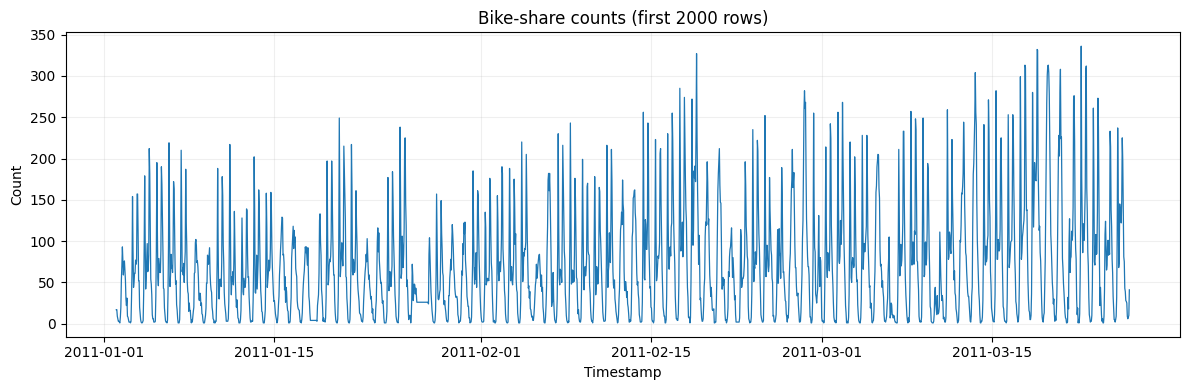

Saved: C:\Users\ericb\source\bike_forecast\results\eda_timeseries.png


In [4]:
# Time series (sample for readability)
sample_n = 2000   # adjust as needed
sample = df.iloc[:sample_n]

plt.figure(figsize=(12,4))
plt.plot(sample['timestamp'], sample['cnt'], linewidth=0.9)
plt.xlabel('Timestamp')
plt.ylabel('Count')
plt.title(f'Bike-share counts (first {sample_n} rows)')
plt.grid(alpha=0.2)
plt.tight_layout()
ts_path = RESULTS / 'eda_timeseries.png'
plt.savefig(ts_path, dpi=150)
plt.show()
print("Saved:", ts_path)

## Hour-of-day and Day-of-week aggregation plots

Show average demand by hour and by day-of-week to reveal diurnal/weekly patterns.

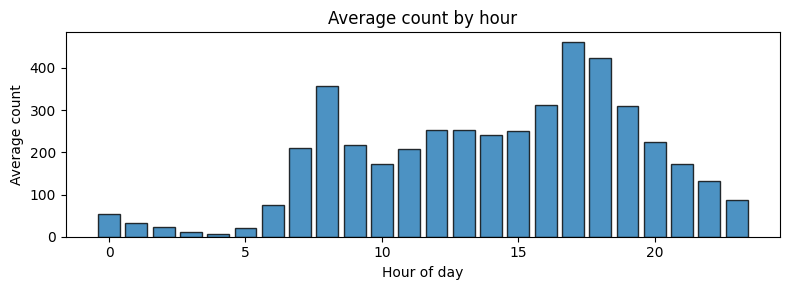

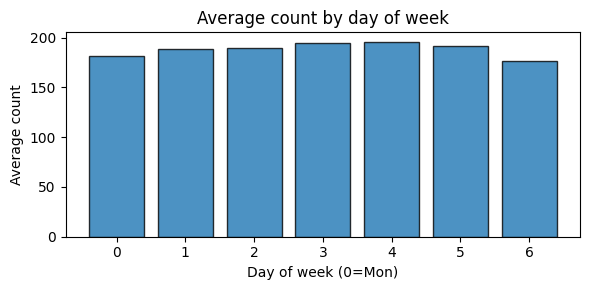

Saved: C:\Users\ericb\source\bike_forecast\results\eda_hour_mean.png C:\Users\ericb\source\bike_forecast\results\eda_dow_mean.png


In [5]:
# Average count by hour
hourly = df.groupby(df['timestamp'].dt.hour)['cnt'].mean()
plt.figure(figsize=(8,3))
plt.bar(hourly.index, hourly.values, edgecolor='k', alpha=0.8)
plt.xlabel('Hour of day')
plt.ylabel('Average count')
plt.title('Average count by hour')
plt.tight_layout()
hour_path = RESULTS / 'eda_hour_mean.png'
plt.savefig(hour_path, dpi=150)
plt.show()

# Average count by day of week
dow = df.groupby(df['timestamp'].dt.dayofweek)['cnt'].mean()
plt.figure(figsize=(6,3))
plt.bar(dow.index, dow.values, edgecolor='k', alpha=0.8)
plt.xlabel('Day of week (0=Mon)')
plt.ylabel('Average count')
plt.title('Average count by day of week')
plt.tight_layout()
dow_path = RESULTS / 'eda_dow_mean.png'
plt.savefig(dow_path, dpi=150)
plt.show()

print("Saved:", hour_path, dow_path)

## Heatmap: day-of-week Ã— hour

Visualize mean counts per (day-of-week, hour) as a heatmap.

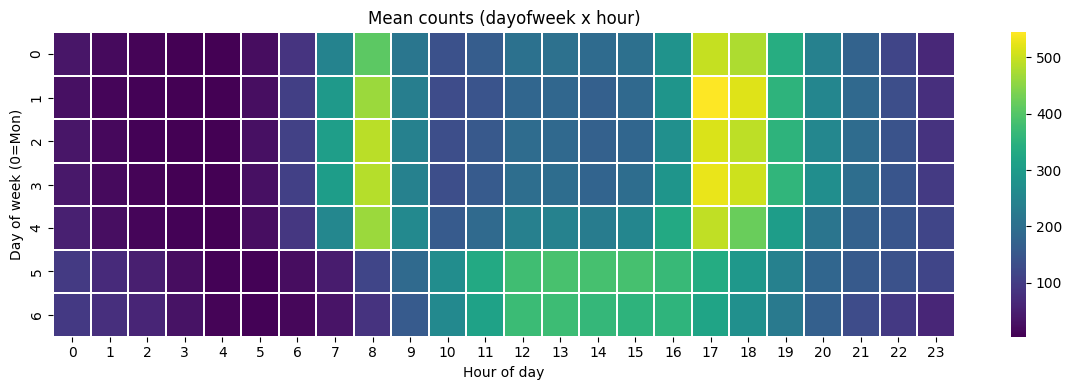

Saved: C:\Users\ericb\source\bike_forecast\results\eda_heatmap_day_hour.png


In [6]:
# Pivot and heatmap
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['hour'] = df['timestamp'].dt.hour
pivot = df.pivot_table(index='dayofweek', columns='hour', values='cnt', aggfunc='mean').fillna(0)

plt.figure(figsize=(12,4))
sns.heatmap(pivot, cmap='viridis', linewidths=0.3)
plt.ylabel('Day of week (0=Mon)')
plt.xlabel('Hour of day')
plt.title('Mean counts (dayofweek x hour)')
plt.tight_layout()
heatmap_path = RESULTS / 'eda_heatmap_day_hour.png'
plt.savefig(heatmap_path, dpi=150)
plt.show()

print("Saved:", heatmap_path)

## Histograms of counts and temperature

Reveal distribution/skewness and outliers.

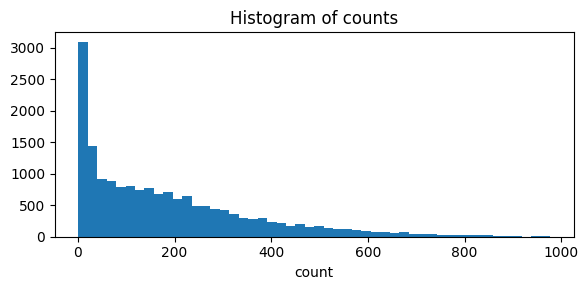

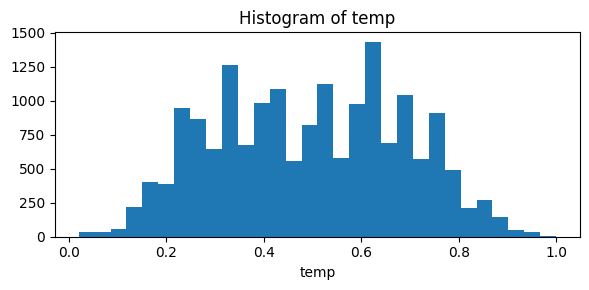

Saved: C:\Users\ericb\source\bike_forecast\results\eda_hist_cnt.png C:\Users\ericb\source\bike_forecast\results\eda_hist_temp.png


In [7]:
# Histogram of counts
plt.figure(figsize=(6,3))
plt.hist(df['cnt'], bins=50)
plt.title('Histogram of counts')
plt.xlabel('count')
plt.tight_layout()
hist_cnt = RESULTS / 'eda_hist_cnt.png'
plt.savefig(hist_cnt, dpi=150)
plt.show()

# Histogram of temperature (if exists)
if 'temp' in df.columns:
    plt.figure(figsize=(6,3))
    plt.hist(df['temp'], bins=30)
    plt.title('Histogram of temp')
    plt.xlabel('temp')
    plt.tight_layout()
    hist_temp = RESULTS / 'eda_hist_temp.png'
    plt.savefig(hist_temp, dpi=150)
    plt.show()
    print("Saved:", hist_cnt, hist_temp)
else:
    print("Saved:", hist_cnt)

## Missing value analysis & resampling notes

Check for missing values and add notes about resampling if you use raw trip-level data.

In [8]:
# Missing values summary
missing = df.isna().sum()
display(missing)

# Save missing summary
import json
with open(RESULTS / 'eda_missing.json', 'w') as f:
    json.dump(missing.to_dict(), f, indent=2)
print("Saved missing-value summary to results/eda_missing.json")

# Resampling note:
print("""
Resampling note:
- UCI hour.csv is already hourly (no resampling required).
- If you use raw trip-level data: set timestamp as index and use:
    df_ts = raw_df.set_index('timestamp').resample('H').agg({'trip_id':'count'})
  Or aggregate trips per station with groupby + resample.
""")

timestamp        0
instant          0
season           0
yr               0
mnth             0
hr               0
holiday          0
weekday          0
workingday       0
weathersit       0
temp             0
atemp            0
hum              0
windspeed        0
casual           0
registered       0
cnt              0
hour             0
dayofweek        0
is_weekend       0
month            0
year             0
hour_sin         0
hour_cos         0
dayofweek_sin    0
dayofweek_cos    0
month_sin        0
month_cos        0
lag_1            0
lag_3            0
lag_6            0
lag_24           0
rolling_3        0
rolling_24       0
dtype: int64

Saved missing-value summary to results/eda_missing.json

Resampling note:
- UCI hour.csv is already hourly (no resampling required).
- If you use raw trip-level data: set timestamp as index and use:
    df_ts = raw_df.set_index('timestamp').resample('H').agg({'trip_id':'count'})
  Or aggregate trips per station with groupby + resample.



## Feature correlation heatmap

Show correlation among numeric features (helpful for feature selection).

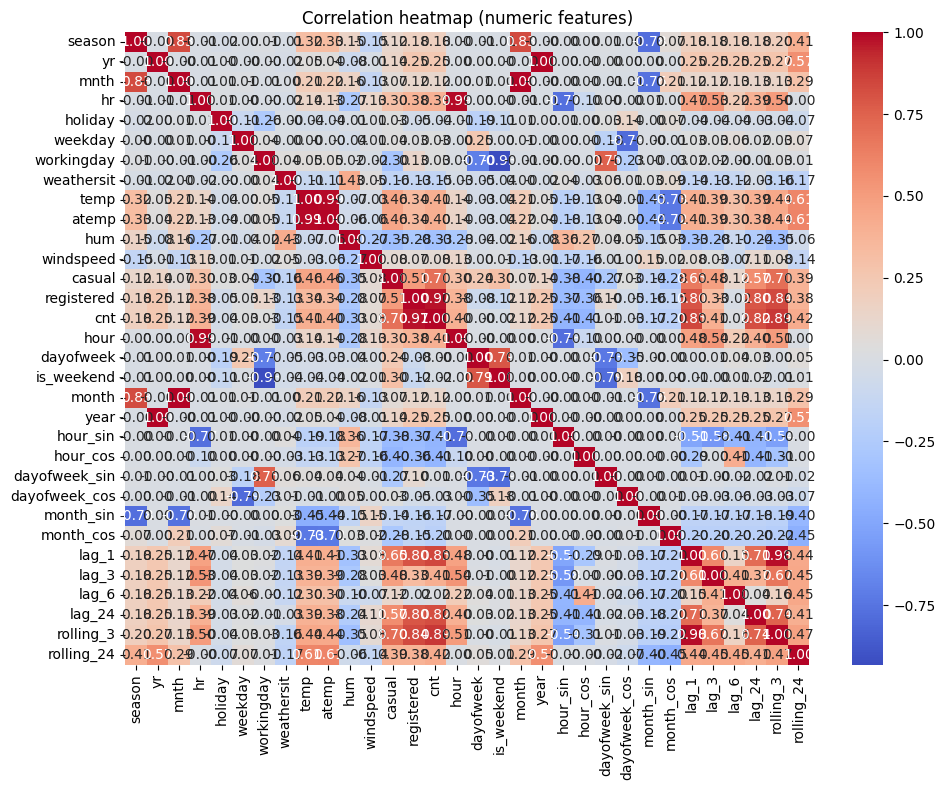

Saved: C:\Users\ericb\source\bike_forecast\results\eda_corr.png


In [9]:
# Correlation heatmap (numeric columns)
numeric = df.select_dtypes(include=['number']).drop(columns=['instant'], errors='ignore')
corr = numeric.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=False)
plt.title('Correlation heatmap (numeric features)')
plt.tight_layout()
corr_path = RESULTS / 'eda_corr.png'
plt.savefig(corr_path, dpi=150)
plt.show()
print("Saved:", corr_path)

## Quick conclusions

The distribution of hourly bike-share demand is strongly non-uniform, with a mean of 188 rides/hour and a median of 140 rides/hour, indicating a right-skewed pattern (skew = 1.28) driven by high-demand rush hours. Counts range from 1 to 977, showing a long right tail with occasional extreme peaks. Temperature (normalized 0â€“1) is centered around 0.50, roughly symmetric, and shows a moderate positive correlation with demand (r = 0.41), meaning warmer conditions generally increase ridership. No missing values were detected, and the dataset appears clean and suitable for modeling after feature engineering.

### Key Patterns

#### Demand distribution:

Mean = 188, median = 140, std = 181
Right-skewed with a long high-demand tail (max = 977 rides/hour)

#### Rush-hour behavior:

Skewness (1.28) and kurtosis (1.43) confirm strong commuter peaks.

#### Temperature effects:

Temperature correlates positively with demand (r = 0.41)
Warmer hours tend to produce noticeably higher usage

#### Data quality:

No missing values
All numeric ranges are valid and consistent with expected bike-share behavior

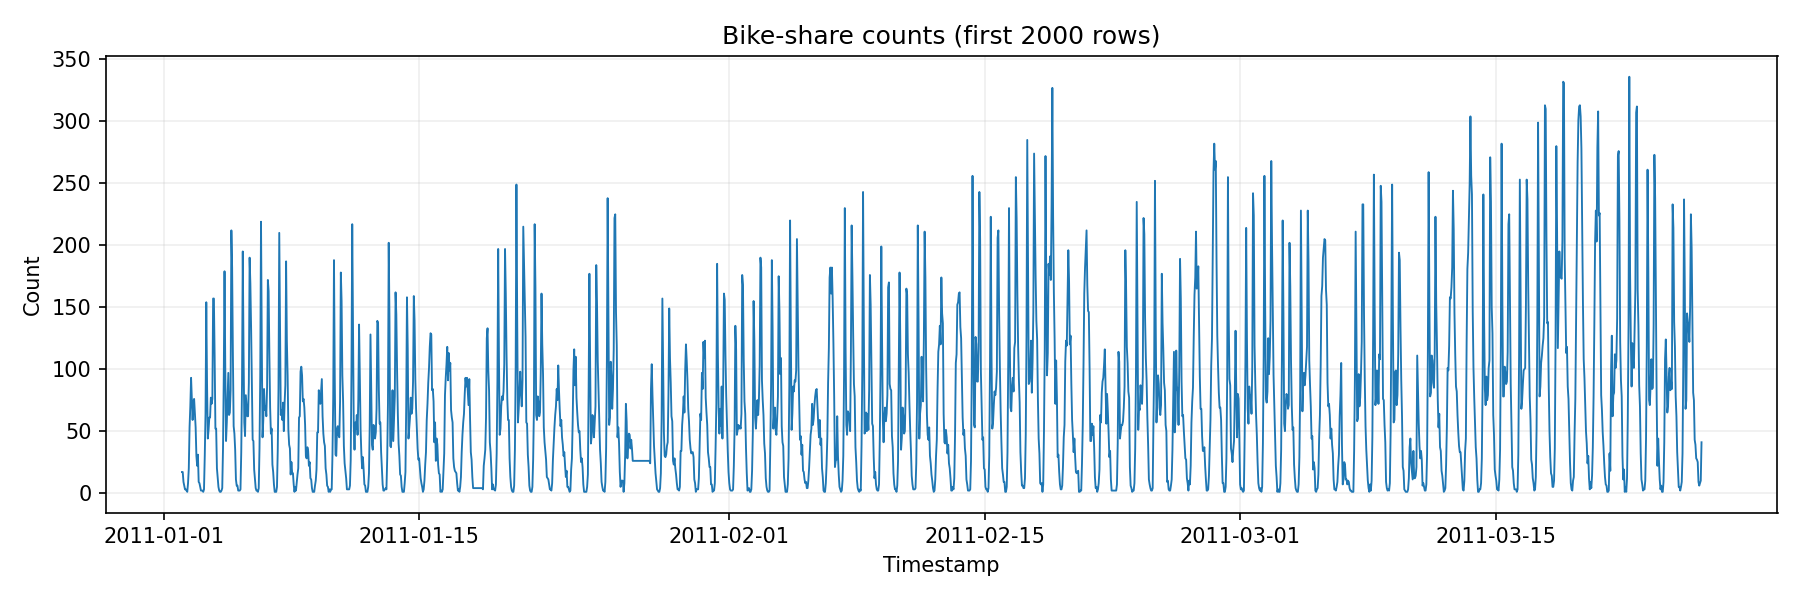

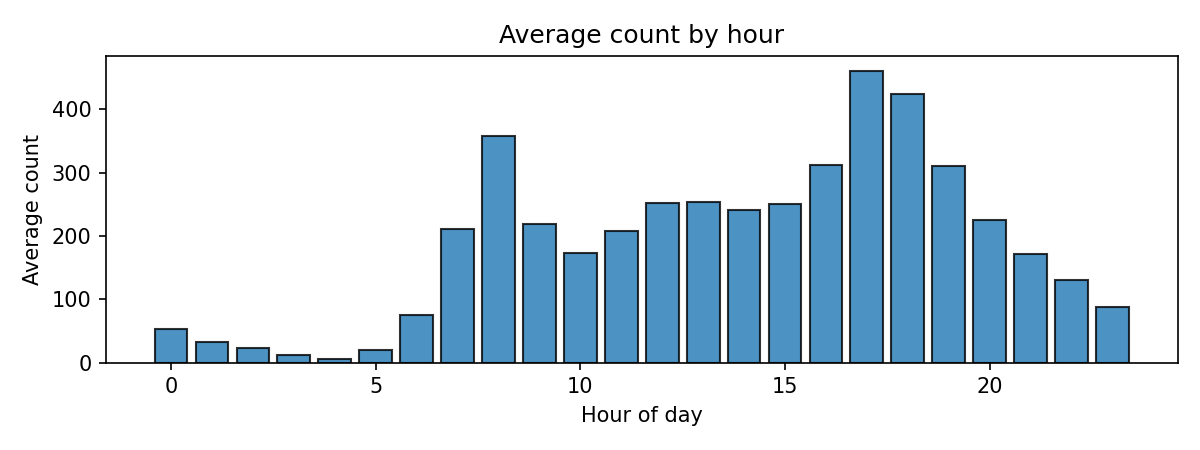

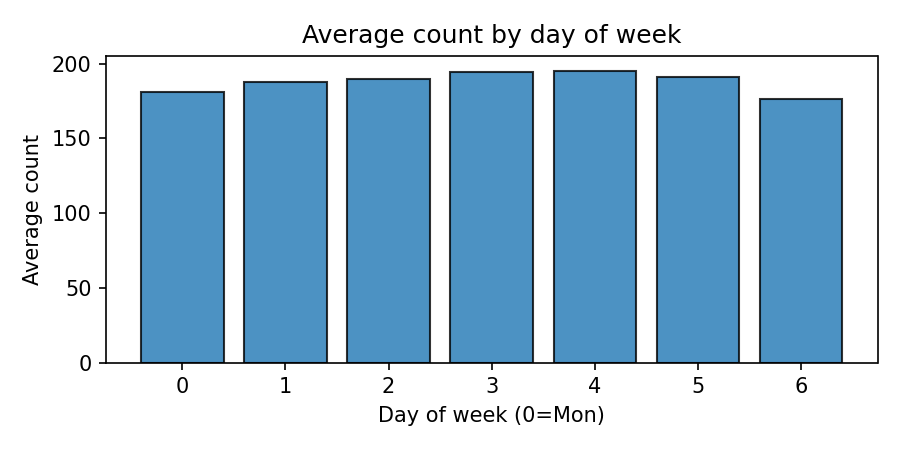

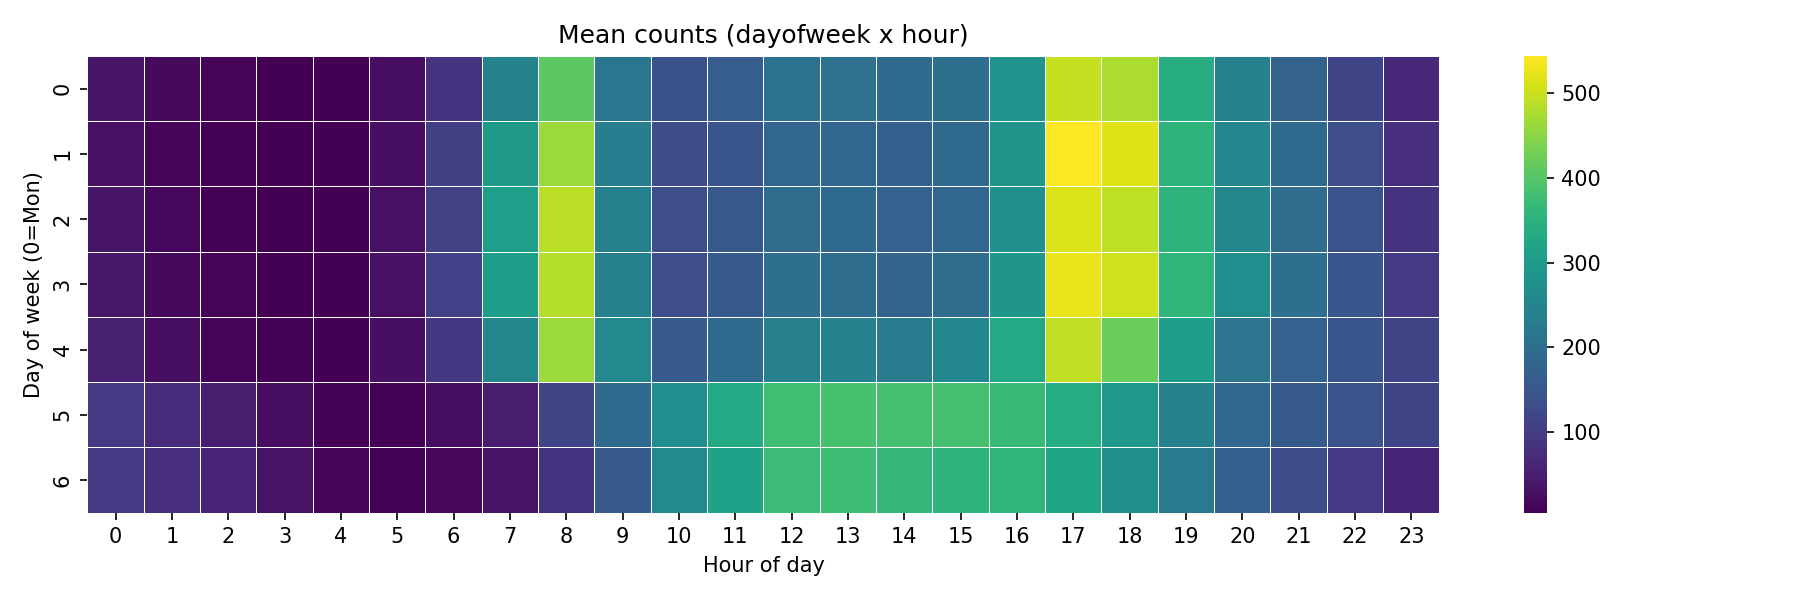

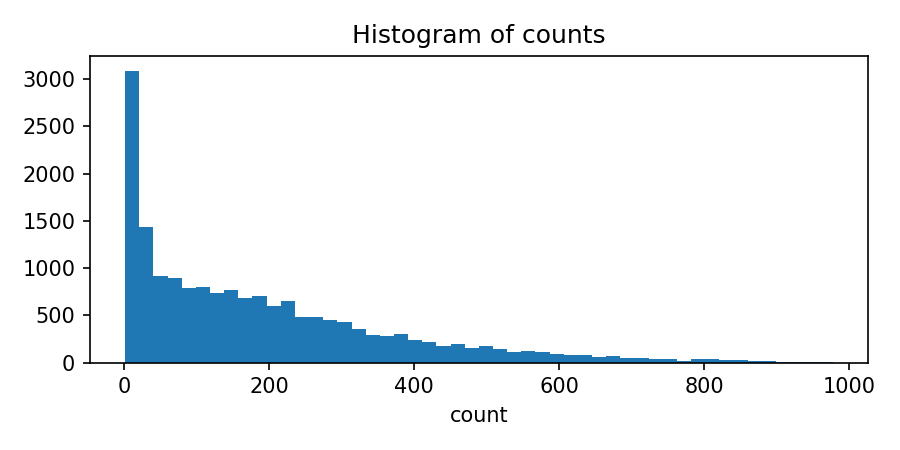

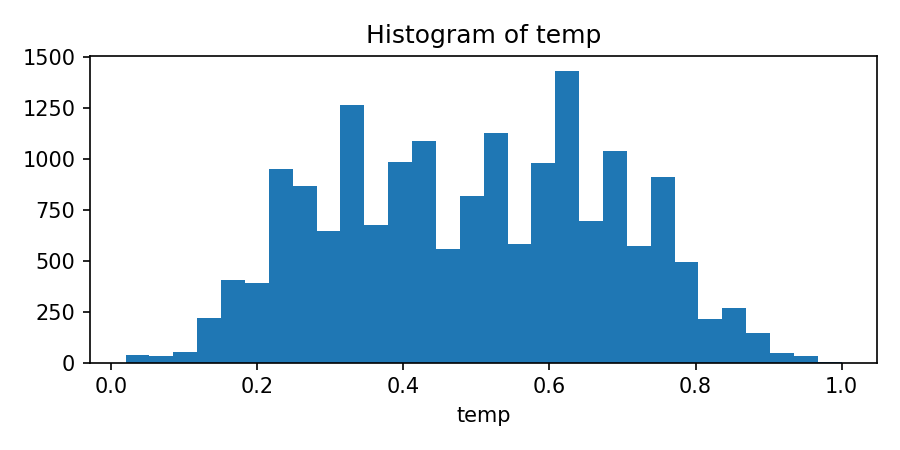

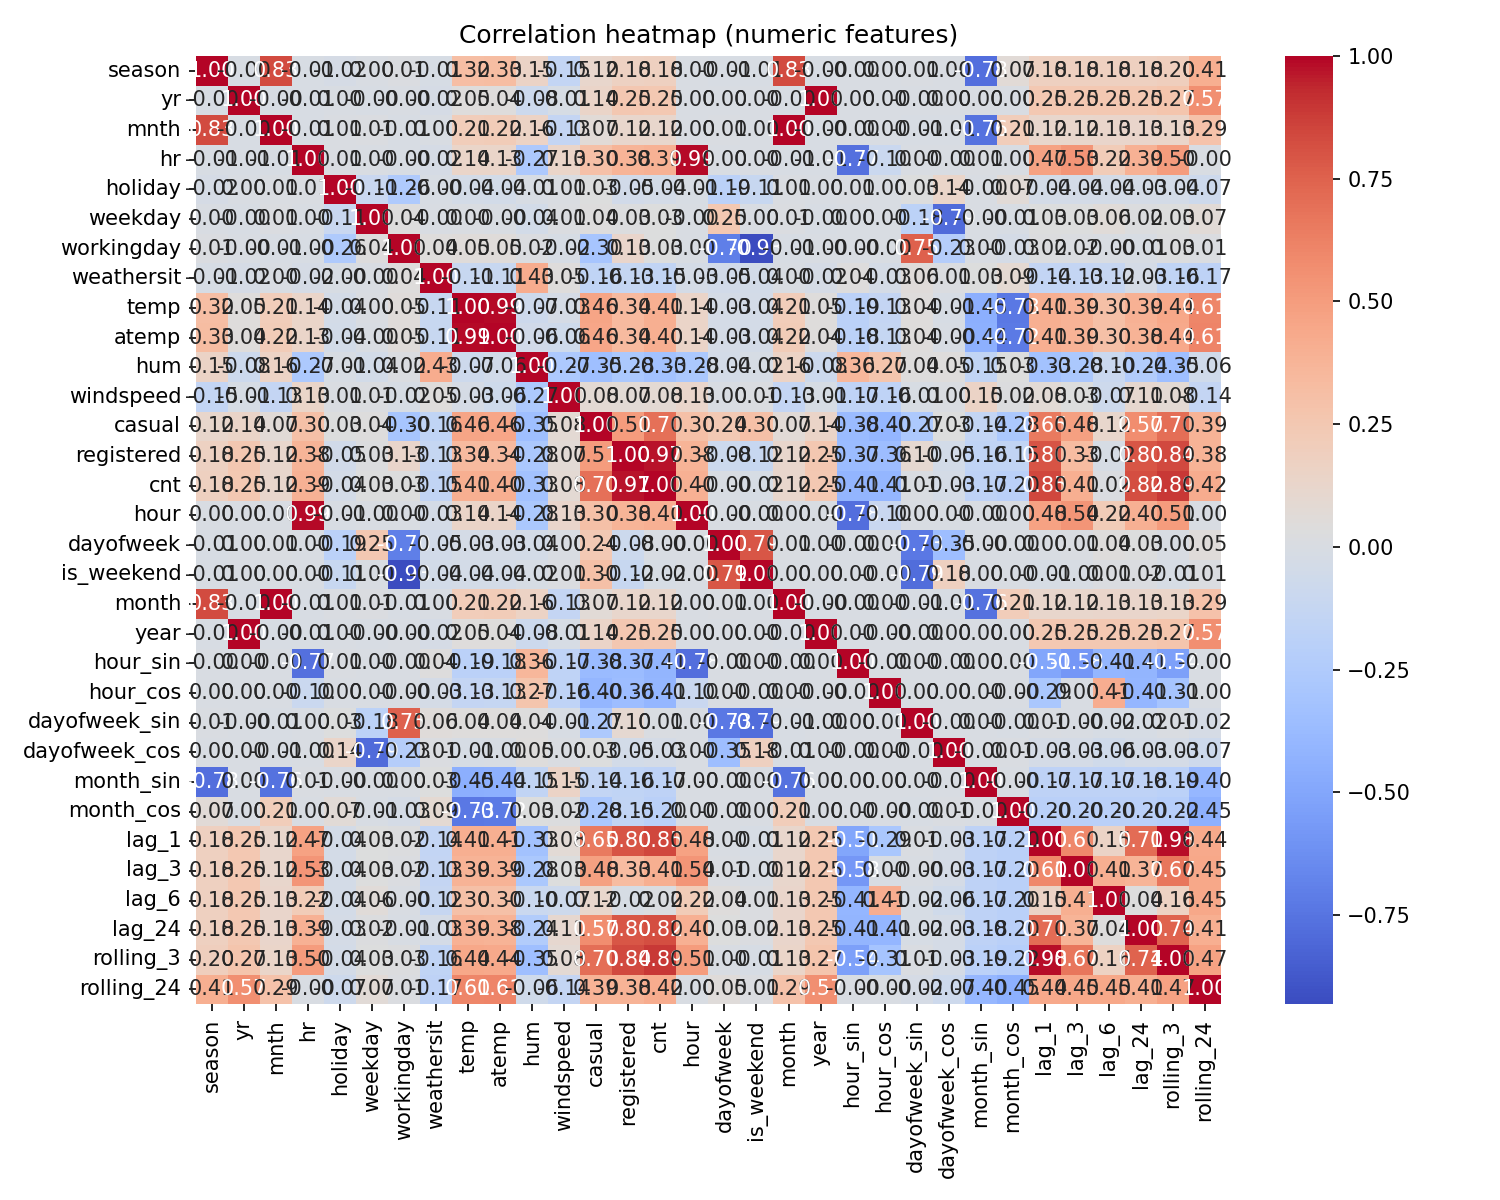

In [10]:
# Display saved images inline (useful if you rerun the notebook)
from IPython.display import Image, display
for img in ['eda_timeseries.png','eda_hour_mean.png','eda_dow_mean.png','eda_heatmap_day_hour.png','eda_hist_cnt.png','eda_hist_temp.png','eda_corr.png']:
    p = RESULTS / img
    if p.exists():
        display(Image(str(p)))

In [11]:
df['cnt'].describe().to_dict()

{'count': 17520.0,
 'mean': 187.9961187214612,
 'std': 181.38373916411788,
 'min': 1.0,
 '25%': 38.0,
 '50%': 140.0,
 '75%': 280.0,
 'max': 977.0}

In [12]:
df['temp'].describe().to_dict()   # if present

{'count': 17520.0,
 'mean': 0.49541210045662093,
 'std': 0.19313635350111333,
 'min': 0.02,
 '25%': 0.34,
 '50%': 0.5,
 '75%': 0.66,
 'max': 1.0}

In [13]:
df['cnt'].skew(), df['cnt'].kurtosis()

(np.float64(1.2834402964546023), np.float64(1.4311493824989747))

In [14]:
df[['cnt','temp']].corr().loc['cnt','temp']

np.float64(0.4084596097834049)